In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm_notebook as tqdm
from L96 import *
from copy import copy, deepcopy
import pdb
import multiprocessing as mp

## Learn a wrong parameterization - polynomial

In [95]:
h = xr.open_dataset('L96TwoLevelHistory.nc')
hpert = xr.open_dataset('L96TwoLevelHistory_pert2.nc')

In [96]:
h.X

<xarray.DataArray 'X' (time: 100001, x: 36)>
[3600036 values with dtype=float64]
Coordinates:
  * time     (time) float64 0.0 0.001 0.002 0.003 0.004 0.005 0.006 0.007 ...
  * x        (x) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

In [97]:
p = np.polyfit(hpert.X.values.ravel(), hpert.B.values.ravel(), 4)
p_true = np.polyfit(h.X.values.ravel(), h.B.values.ravel(), 4)
p_true, p

(array([-4.39802978e-04,  6.64583654e-03,  4.90003557e-03, -4.94175941e-01,
        -1.82204664e-01]),
 array([-3.48071428e-06,  4.15956018e-04, -1.91242472e-03, -1.02298046e-01,
        -3.14598327e-02]))

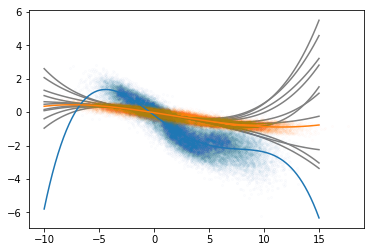

In [144]:
sigmas = np.abs(p)/1000
plt.scatter(h.X[::100], h.B[::100], s=5, alpha=0.01)
plt.scatter(hpert.X[::100], hpert.B[::100], s=5, alpha=0.01)
tmp = np.linspace(-10, 15, 100)
plt.plot(tmp, np.polyval(p_true, tmp))
plt.plot(tmp, np.polyval(p, tmp))
for i in range(10):
    plt.plot(tmp, np.polyval(p + np.random.normal(0, np.sqrt(sigmas)), tmp), c='gray', zorder=0.1)

In [101]:
class L96TwoLevelUncoupledParam(object):
    def __init__(self, K=36, J=10, F=10, dt=0.001, param=None,
                 X_init=None, noprog=False, save_dt=0.1):
        self.K, self.J, self.F, self.dt = K, J, F, dt
        self.noprog = noprog
        self.param = param
        self.step_count = 0
        self.save_steps = int(save_dt / dt)
        self.X = np.random.rand(self.K) if X_init is None else X_init.copy()
        self._history_X = [self.X.copy()]
        self._history_B = [np.zeros(self.X.shape)]

    def _rhs_X(self, X, B):
        """Compute the right hand side of the X-ODE."""
        dXdt = (
                -np.roll(X, -1) * (np.roll(X, -2) - np.roll(X, 1)) -
                X + self.F + B
        )
        return dXdt

    def step(self):
        # First get solution for X without updating Y
        B = self.param(self.X)
        
        k1_X = self.dt * self._rhs_X(self.X, 0)
        k2_X = self.dt * self._rhs_X(self.X + k1_X / 2, 0)
        k3_X = self.dt * self._rhs_X(self.X + k2_X / 2, 0)
        k4_X = self.dt * self._rhs_X(self.X + k3_X, 0)

        # Then update both
        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X) + self.dt * B

        self.step_count += 1

        if self.step_count % self.save_steps == 0:

            self._history_X.append(self.X.copy())
            self._history_B.append(B.copy())

    def iterate(self, time):
        steps = int(time / self.dt)
        for n in tqdm(range(steps), disable=self.noprog):
            self.step()

    @property
    def state(self):
        return np.concatenate([self.X])

    def set_state(self, x):
        self.X = x[:self.K]

    @property
    def history(self):
        dic = {}
        dic['X'] = xr.DataArray(self._history_X, dims=['time', 'x'], name='X')
        dic['B'] = xr.DataArray(self._history_B, dims=['time', 'x'], name='B')
        return xr.Dataset(
            dic,
            coords={'time': np.arange(len(self._history_X)) * self.dt, 'x': np.arange(self.K),
                    'y': np.arange(self.K * self.J)}
        )

In [102]:
class PolyParam():
    def __init__(self, p):
        self.p = p
    def __call__(self, x):
        return np.polyval(self.p, x)

In [103]:
def multi_helper(l, nt):
    l.iterate(nt)
    return l

In [104]:
# Create initial conditions
l96 = L96TwoLevelUncoupled(dt=0.001)
l96.iterate(100)
init2 = l96.state
init2X = l96.X
init2Y = l96.Y

KeyboardInterrupt: 

In [ ]:
# Compute true statistics and variances
X_true = h.X.values.mean(0)
B_true = h.B.values.mean(0)
X2_true = (h.X.values**2).mean(0)
XB_true = (h.X * h.B).values.mean(0)

X_var = h.X.values.var(0)
B_var = h.B.values.var(0)
X2_var = (h.X.values**2).var(0)
XB_var = (h.X * h.B).values.var(0)

In [ ]:
def H(l):
    return np.concatenate([
        np.array(l._history_X).mean(0),
        np.array(l._history_B).mean(0),
        (np.array(l._history_X)**2).mean(0),
        (np.array(l._history_X)*np.array(l._history_B)).mean(0),
    ])

In [105]:
def param_state(l):
    return l.param.p

In [106]:
class EnKFParamClimate2():
    def __init__(self, l96, nens, obs_noise, cyc_len, y,
                 H=lambda l: l.state, state=lambda l: l.state, mp=None,
                 par_noise=0, ):
        self.y = y
        self.l96 = l96
        self.nens = nens
        self.obs_noise = obs_noise
        self.R = np.diag(np.ones(H(l96).shape) * obs_noise)
        self.cyc_len = cyc_len
        self.mp = mp
        self.H, self.state, self.par_noise = H, state, par_noise
        
    def initialize(self, ic, ic_noise, priors, sigmas):
        # Initial conditions
        self.ic=ic
        self.ic_noise=ic_noise
        self.x_t = ic.copy()
        self.x_a = ic.copy() + np.random.normal(0, ic_noise, self.x_t.shape)
        self.x_a_ens = np.array([ic.copy()] * self.nens)
        self.x_a_ens += np.random.normal(0, ic_noise, self.x_a_ens.shape)
        
        # Models
        self.l96_det = deepcopy(self.l96); self.l96_det.set_state(self.x_a)
        self.l96_det.param.p = priors
    
        self.l96_ens = [deepcopy(self.l96) for n in range(self.nens)]
        for i, l in enumerate(self.l96_ens):
            l.set_state(self.x_a_ens[i])
            l.param.p = priors + np.random.normal(0, np.sqrt(sigmas))

        self.p_det = [self.l96_det.param.p]; self.p_ens = [[l.param.p for l in self.l96_ens]]
        
    def step(self):
        # Forecast
        if self.mp is None:
            self.l96_det.iterate(self.cyc_len)
            for l in self.l96_ens:
                l.iterate(self.cyc_len)
        else:
            self.mp_forecast()
        
        # Get arrays
        #pdb.set_trace()
        self.x_f = self.state(self.l96_det)
        self.x_f_ens = np.array([self.state(l) for l in self.l96_ens])
        self.hx_f = self.H(self.l96_det)
        self.hx_f_ens = np.array([self.H(l) for l in self.l96_ens])
        
        # New analysis
        K = self.kalman_gain(self.x_f_ens, self.hx_f_ens)
        self.x_a = self.x_f + K @ (self.y - self.hx_f)
        self.x_a_ens = np.array([
            self.x_f_ens[i] + K @ (
                (self.y + np.random.normal(0, np.sqrt(self.obs_noise), self.obs_noise.shape)) 
                - self.hx_f_ens[i]) for i in range(self.nens)
        ])
        
        # Update state in models
        self.l96_det.param.p = self.x_a

        for i, l in enumerate(self.l96_ens):
            l.param.p = self.x_a_ens[i] + np.random.normal(0, self.par_noise)

        # Update parameter history
        self.p_det.append(self.l96_det.param.p); 
        self.p_det.append([l.param.p for l in self.l96_ens])
        
        print('Ensemble mean p = ', self.x_a_ens.mean(0))
        loss = 
        print('Loss = ', loss)
        
        # Erase history and reset ic
        self.l96_det._history_X = [] 
        self.l96_det._history_B = [] 
        self.l96_det.set_state(self.ic.copy() + np.random.normal(0, self.ic_noise, self.ic.shape))
        for l in self.l96_ens:
            l._history_X = [] 
            l._history_B = [] 
            l.set_state(self.ic.copy() + np.random.normal(0, self.ic_noise, self.ic.shape))
    
    def kalman_gain(self, x_f_ens, hx_f_ens):
        X = (x_f_ens - x_f_ens.mean(0)).T
        Y = (hx_f_ens - hx_f_ens.mean(0)).T
        K = X @ Y.T @ inv(Y @ Y.T + (self.nens -1) * self.R)
        return K
        
    def iterate(self, ncycles, noprog=False):
        for n in tqdm(range(ncycles), disable=noprog):
            self.step() 
            
    def mp_forecast(self):
        all_ls = [self.l96_det] + self.l96_ens
        pool = mp.Pool(processes=self.mp)
        results = [pool.apply_async(multi_helper, args=(l, self.cyc_len)) for l in all_ls]
        all_ls = [p.get() for p in results]
        pool.close()
        self.l96_det, self.l96_ens = all_ls[0], all_ls[1:]

In [107]:
r = 0.5

In [129]:
y = np.concatenate([X_true, B_true, X2_true, XB_true])
var = np.concatenate([X_var, B_var, X2_var, XB_var])

In [151]:
enkf = EnKFParamClimate2(
    L96TwoLevelUncoupledParam(noprog=True, X_init=init2X, dt=0.001, param=PolyParam(p)), 
    y=y,
    nens=100, 
    obs_noise = r**2 * var, 
    cyc_len=2, 
    mp=50, 
    state=param_state,
    H=H,
    par_noise=0,
)

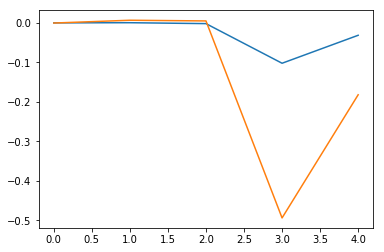

In [152]:
plt.plot(p)
plt.plot(p_true)

In [153]:
enkf.initialize(init2X, ic_noise=0, priors=p, sigmas=np.abs(p)/1000)

In [155]:
enkf.iterate(5)

Ensemble mean p =  [-1.14537690e-04 -2.01088263e-03 -3.55784790e-03 -1.25440563e-01
 -3.23498045e-02]
Ensemble mean p =  [-1.18577201e-04 -2.31255464e-03 -4.00215485e-03 -1.33658784e-01
 -3.41698091e-02]
Ensemble mean p =  [-1.15625389e-04 -2.50106377e-03 -4.49741055e-03 -1.40594458e-01
 -3.58373359e-02]
Ensemble mean p =  [-1.12033825e-04 -2.65586100e-03 -4.91094546e-03 -1.46589291e-01
 -3.71089571e-02]
Ensemble mean p =  [-1.05708027e-04 -2.80323066e-03 -5.20959341e-03 -1.52567659e-01
 -3.84091896e-02]


In [156]:
p_true

array([-4.39802978e-04,  6.64583654e-03,  4.90003557e-03, -4.94175941e-01,
       -1.82204664e-01])

In [162]:
np.array(enkf.p_det).shape

(13,)

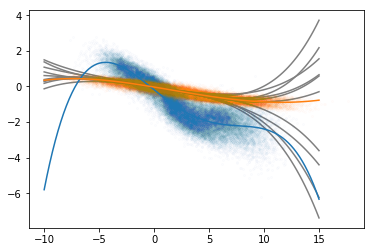

In [161]:
sigmas = np.abs(p)/1000
plt.scatter(h.X[::100], h.B[::100], s=5, alpha=0.01)
plt.scatter(hpert.X[::100], hpert.B[::100], s=5, alpha=0.01)
tmp = np.linspace(-10, 15, 100)
plt.plot(tmp, np.polyval(p_true, tmp))
plt.plot(tmp, np.polyval(p, tmp))
for i in range(10):
    plt.plot(tmp, np.polyval(np.array(enkf.p_ens)[0, i, :], tmp), 
             c='gray', zorder=0.1)

In [121]:
l.history.X

<xarray.DataArray 'X' (time: 1001, x: 36)>
array([[ 6.418281,  4.979288,  1.553455, ...,  0.565876, -1.620249, -1.516248],
       [ 3.816017,  6.282482,  3.585205, ...,  1.256304,  0.602114, -3.521331],
       [-0.641124,  6.590116,  5.305781, ...,  2.933991,  1.350161, -3.047739],
       ...,
       [ 0.079917,  7.118746,  3.607969, ...,  5.645903,  0.938664, -4.357739],
       [-3.696319,  7.682784,  3.177943, ...,  6.196281, -0.537747, -1.452206],
       [-3.632605,  7.529012,  1.758902, ...,  6.356515,  1.133779,  2.553009]])
Coordinates:
  * time     (time) float64 0.0 0.001 0.002 0.003 0.004 0.005 0.006 0.007 ...
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

In [ ]:
def plot_params(enkf):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    def panel(ax, det, ens, title):
        ens = np.array(ens)
        print(title, ' mean = ', ens[-1].mean(), ' / std = ', ens[-1].std())
        for i in range(enkf.nens):
            ax.plot(ens[:, i], c='gray')
        ax.plot(det, c='r')
        ax.set_title(title)
    for i in range(enkf.param.p.shape[0]):
    panel(axs[0], enkf.F_det, enkf.F_ens, 'F')
    panel(axs[1], enkf.h_det, enkf.h_ens, 'h')
    panel(axs[2], enkf.c_det, enkf.c_ens, 'c')
    panel(axs[3], enkf.b_det, enkf.b_ens, 'b')